In [ ]:
!pip install timm==0.1.30

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import glob
import os
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import cv2
from torchvision.utils import save_image

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
import albumentations as A

from tqdm.notebook import tqdm

import timm

# Model - Efficientnet_b3

In [ ]:
# m = timm.create_model('efficientnet_b3', pretrained=True)

In [ ]:
# num_classes = 18
# m.classifier = nn.Sequential(
#     nn.Linear(1536, 1000),
#     nn.ReLU(True),
#     nn.Dropout(),
#     nn.Linear(1000, 1000),
#     nn.ReLU(True),
#     nn.Dropout(),
#     nn.Linear(1000, num_classes),
# )

# m

# Data Preprocessing - valancing

### 깨끗한 9,408개 데이터

In [8]:
# 이미지 path 저장

img_dir = glob.glob('/opt/ml/input/data/train/images/*')
train_images_path = []

for path in img_dir:
    img_path = glob.glob(os.path.join(path, '*'))
    train_images_path.extend(sorted(img_path))
len(train_images_path)

18900

In [9]:
# class 별 이미지 path 저장

img_dir = glob.glob('/opt/ml/input/data/train/images/*')

class_num = 18
classes = [[] for _ in range(class_num)]

for path in img_dir:
    # gender와 age에 따라 class 설정
    info = path.split('/')[-1].split('_')
    gender, age = info[1], int(info[3])
    c = 0
    if gender == 'female':
        c += 3
        
    if 30 <= age and age < 60:
        c += 1
    elif 60 <= age:
        c += 2
    
    new_c = c
    img_paths = glob.glob(os.path.join(path, '*'))
    for img_path in img_paths:
        c = new_c
        if 'incorrect' in img_path:
            c += 6
        elif 'normal' in img_path:
            c += 12
        classes[c].append(img_path)
        
print(sum(map(len, classes)))

18900


In [39]:
label = [
    'Wear-Male-29', 'Wear-Male-3059', 'Wear-Male-60',
    'Wear-Female-29', 'Wear-Female-3059', 'Wear-Female-60',
    'Incorrect-Male-29', 'Incorrect-Male-3059', 'Incorrect-Male-60',
    'Incorrect-Female-29', 'Incorrect-Female-3059', 'Incorrect-Female-60',
    'NotWear-Male-29', 'NotWear-Male-3059', 'NotWear-Male-60',
    'NotWear-Female-29', 'NotWear-Female-3059', 'NotWear-FeMale-60',
]

In [41]:
for i, c in enumerate(classes):
    print(f"{i} {label[i]:22s}: {len(c)}")

0 Wear-Male-29          : 2745
1 Wear-Male-3059        : 2050
2 Wear-Male-60          : 415
3 Wear-Female-29        : 3660
4 Wear-Female-3059      : 4085
5 Wear-Female-60        : 545
6 Incorrect-Male-29     : 549
7 Incorrect-Male-3059   : 410
8 Incorrect-Male-60     : 83
9 Incorrect-Female-29   : 732
10 Incorrect-Female-3059 : 817
11 Incorrect-Female-60   : 109
12 NotWear-Male-29       : 549
13 NotWear-Male-3059     : 410
14 NotWear-Male-60       : 83
15 NotWear-Female-29     : 732
16 NotWear-Female-3059   : 817
17 NotWear-FeMale-60     : 109


### Class_0(Wear-Male-29): 549 장
- mask 1 만 사용
- 마스크 제대로 썻는지 확인

In [12]:
new_class_0 = [ ]
for path in classes[0]:
    if 'mask1' in path:
        new_class_0.append(path)
        
len(new_class_0)

549

In [43]:
def imshow(img_class, s):
    fig = plt.figure(figsize=(30, 50))
    for i, img_path in enumerate(img_class[s:s+50]):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ax = fig.add_subplot(10, 5, i+1)
        ax.imshow(img)
        info = img_path.split('/')[-2:]
        idx, gender, race, age = info[0].split('_')
        title = str(idx) + ' ' + gender + ' ' + age + ' ' + info[1].split('.')[0]
        ax.set_title(title)

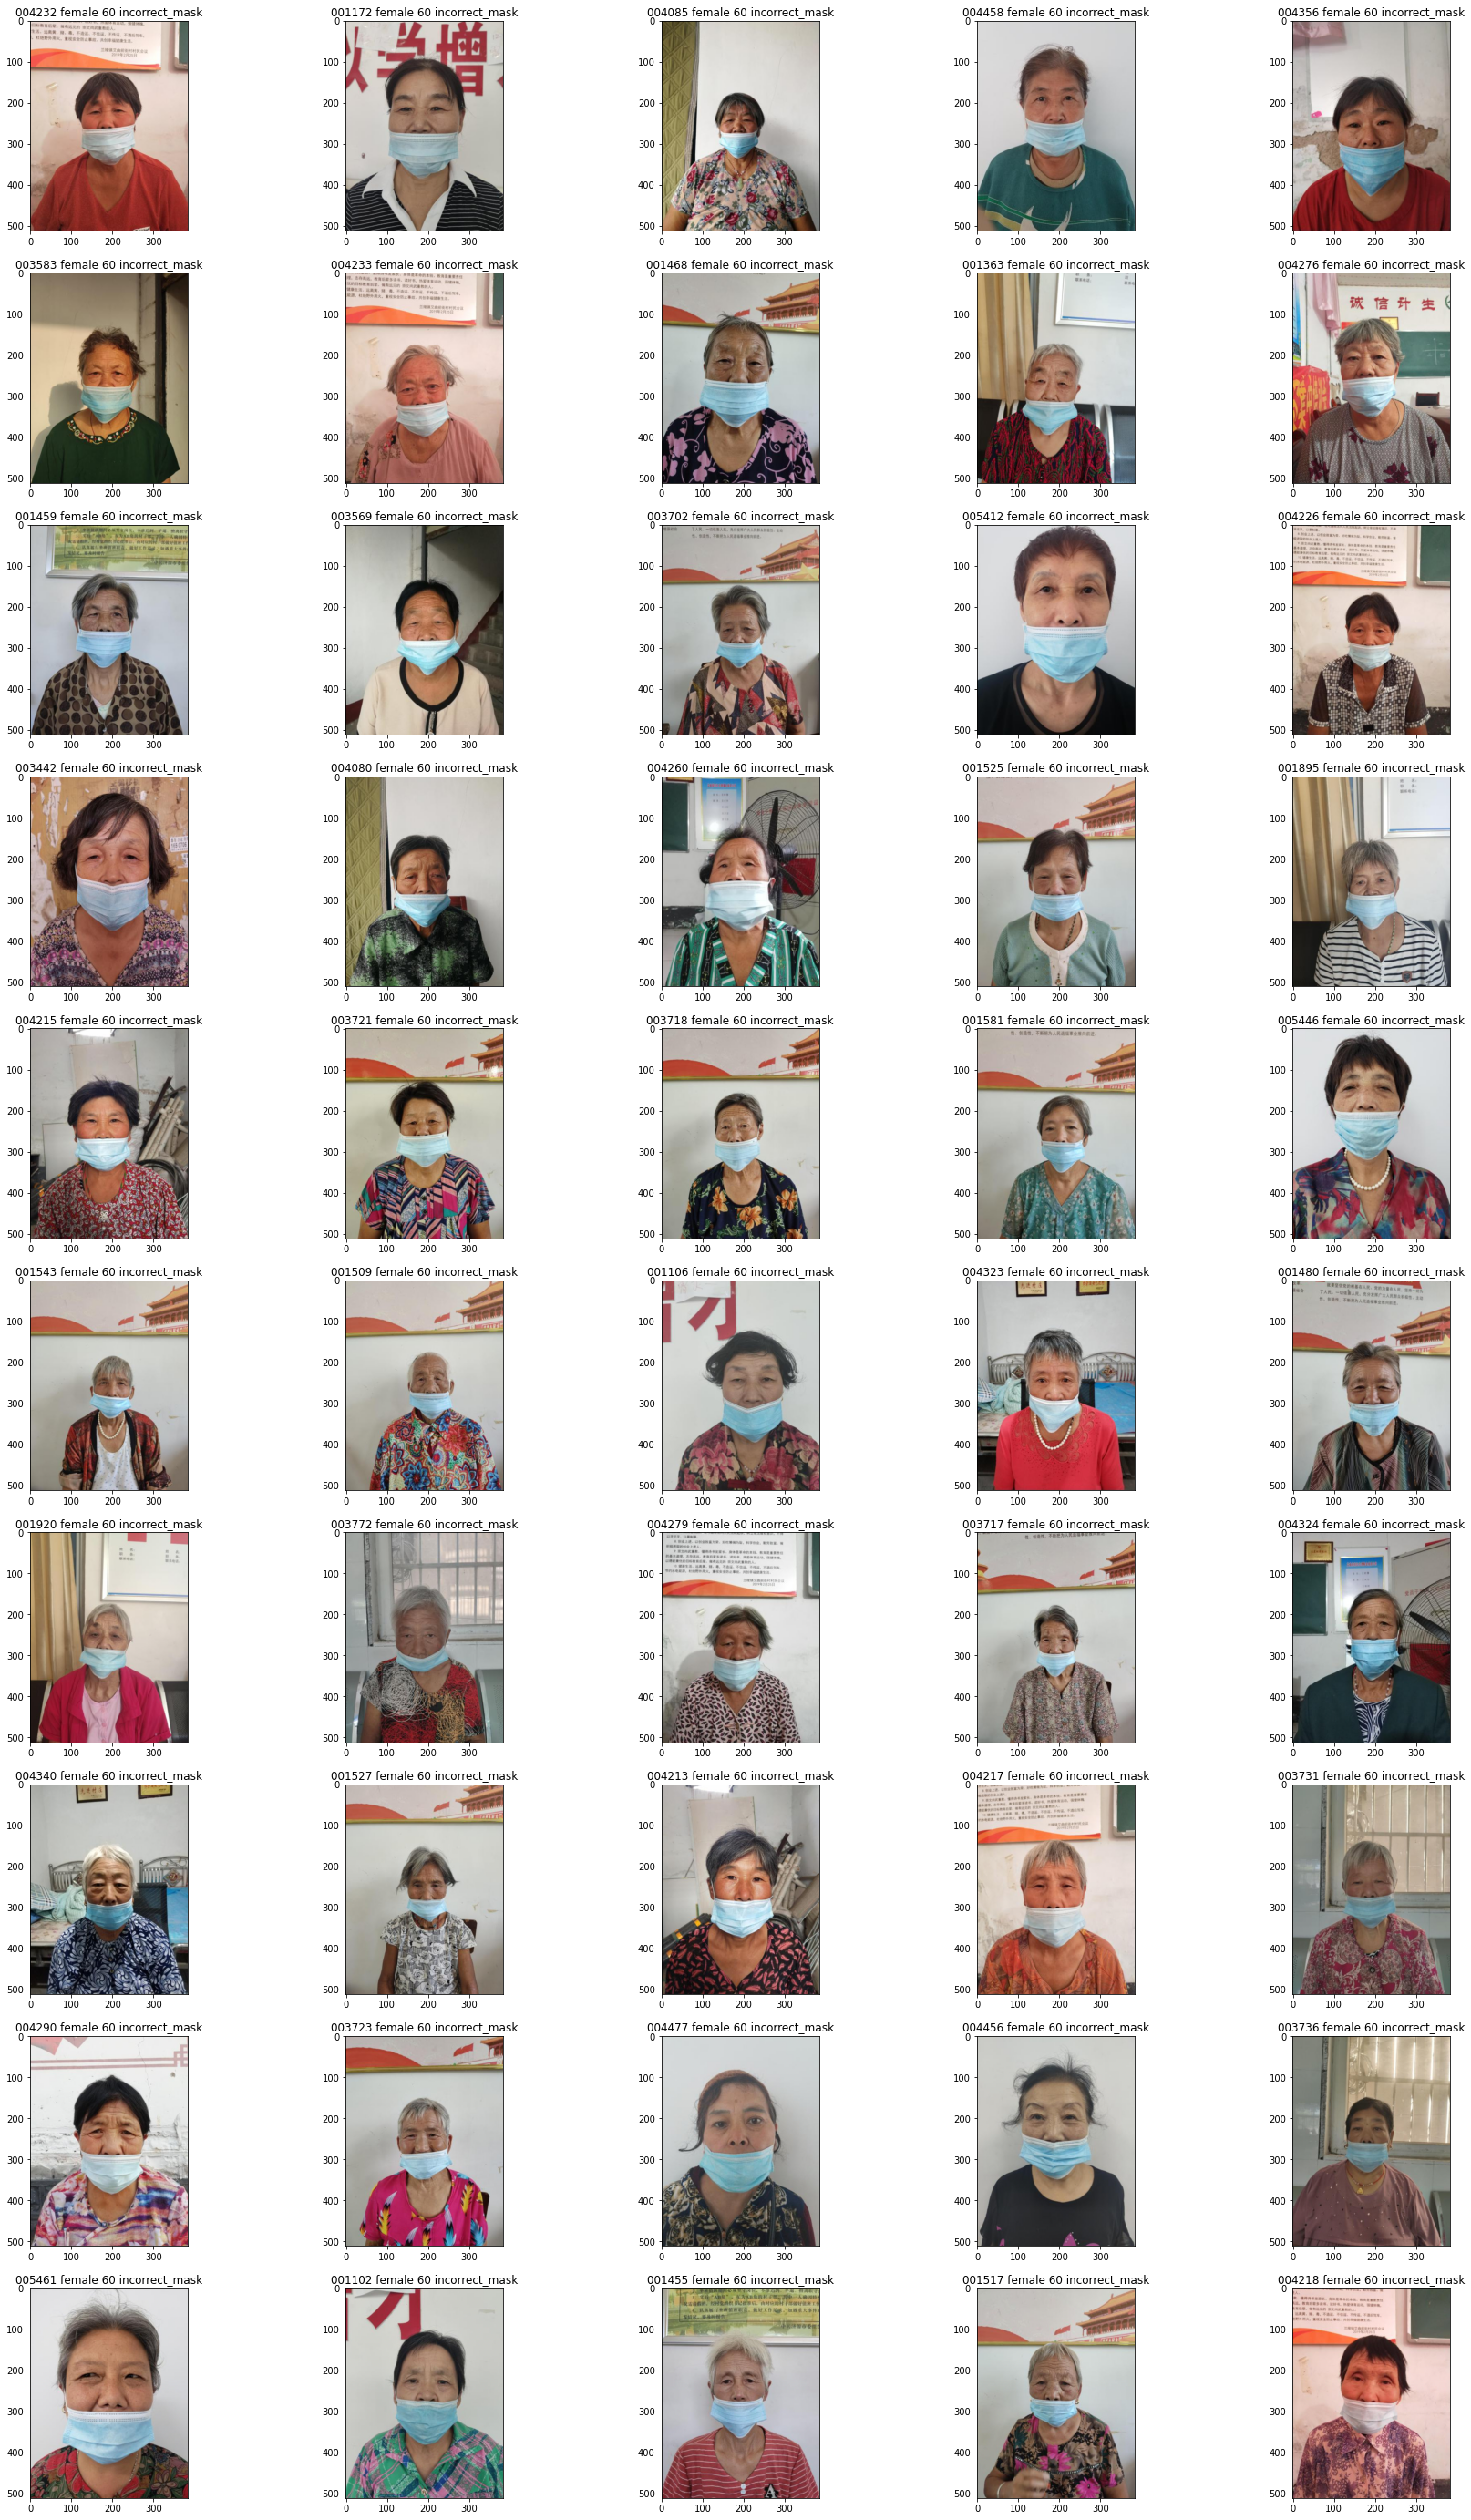

In [60]:
i, s = 11, 5 # 6 7 8 9 10 11
imshow(classes[i], s)

In [ ]:
classes[0].clear()
classes[0] = [path for path in new_class_0]

len(classes[0])

### Class_1(Wear-Male-3059): 410 장
- mask 1 만 사용
- 마스크 제대로 썻는지 확인

In [ ]:
new_classes = [ ]
for path in classes[1]:
    if 'mask1' in path:
        new_classes.append(path)
        
len(new_classes)

In [ ]:
fig = plt.figure(figsize=(30, 50))
for i, img_path in enumerate(new_classes[400:]):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    ax = fig.add_subplot(10, 5, i+1)
    ax.imshow(img)
    info = img_path.split('/')[-2:]
    gender_age = info[0].split('_')
    title = gender_age[1] + ' ' + gender_age[3] + ' ' + info[1].split('.')[0]
    ax.set_title(title)

In [ ]:
i = 1

classes[i].clear()
classes[i] = [path for path in new_classes]

len(classes[i])

### Class_2(Wear-Male-60): 415 장 
- mask 1/2/3/4/5 모두 사용
- 마스크 제대로 썻는지 확인

In [ ]:
print(len(classes[2]))

In [ ]:
fig = plt.figure(figsize=(30, 50))
for i, img_path in enumerate(classes[2][400:]):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    ax = fig.add_subplot(10, 5, i+1)
    ax.imshow(img)
    info = img_path.split('/')[-2:]
    gender_age = info[0].split('_')
    title = gender_age[1] + ' ' + gender_age[3] + ' ' + info[1].split('.')[0]
    ax.set_title(title)

### Class_3(Wear-Female-29): 549 장 
- mask 1 에서도 일부만 사용
- 마스크 제대로 썻는지 확인

In [ ]:
new_classes = [ ]
for path in classes[3]:
    if 'mask1' in path:
        new_classes.append(path)
        
new_classes = new_classes[:549]
len(new_classes)

In [ ]:
fig = plt.figure(figsize=(30, 50))
for i, img_path in enumerate(new_classes[400:450]):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    ax = fig.add_subplot(10, 5, i+1)
    ax.imshow(img)
    info = img_path.split('/')[-2:]
    gender_age = info[0].split('_')
    title = gender_age[1] + ' ' + gender_age[3] + ' ' + info[1].split('.')[0]
    ax.set_title(title)